In [ ]:
# !pip install -qq torch timm gdown tqdm

# !gdown 141MgG4CC7XffVH32hQy7lQ0PKCafskji
# !mkdir -p hmdb51_data
# !unzip -q HMDB51.zip -d hmdb51_data

# LS-ViT HMDB51 Training Notebook
Notebook này tải dữ liệu HMDB51 frame, định nghĩa lại toàn bộ model và pipeline training từ đầu, kèm visualization cho data, metrics và inference.

In [ ]:
from __future__ import annotations
import math
import random
import re
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# import timm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


```js
================================================================================
              MINH HỌA LUỒNG DỮ LIỆU (WORKFLOW) - MODULE ATTENTION
================================================================================

KÝ HIỆU:
  B : Batch size (Số lượng video/ảnh trong 1 lần train)
  N : Số lượng Token (Số patches + cls_token)
  C : Tổng số chiều Embedding (Ví dụ: 768)
  H : Số lượng Heads (Ví dụ: 12)
  D : Số chiều của mỗi Head (D = C // H, Ví dụ: 64)

--------------------------------------------------------------------------------
BƯỚC 1: ĐẦU VÀO & KHỞI TẠO QKV
Code: qkv = self.qkv(x)
--------------------------------------------------------------------------------
[ INPUT ]
    |
    |  Tensor x:  [ B, N, C ]
    |
    v
[ Lớp Linear (self.qkv) ] --> Nhân ma trận, mở rộng chiều gấp 3 lần
    |
    |  Tensor qkv: [ B, N, 3*C ]
    |              (Chứa gộp cả Query, Key, Value nối liền nhau)
    v

--------------------------------------------------------------------------------
BƯỚC 2: TÁCH & SẮP XẾP LẠI (RESHAPE & PERMUTE)
Code: ...reshape(B, N, 3, H, D).permute(2, 0, 3, 1, 4)
--------------------------------------------------------------------------------
[ Reshape ] --> Tách chiều C thành (3, H, D)
    |
    |  Trung gian: [ B, N, 3, H, D ]
    |
    v
[ Permute ] --> Đảo thứ tự trục để tối ưu tính toán song song
    |           Đưa trục (3) lên đầu, gom các Heads lại gần nhau
    |
    |  Output:     [ 3, B, H, N, D ]
    v

--------------------------------------------------------------------------------
BƯỚC 3: TÁCH Q, K, V
Code: q, k, v = qkv.unbind(0)
--------------------------------------------------------------------------------
[ Unbind dim=0 ] --> Tách trục đầu tiên (số 3) thành 3 tensor riêng biệt
    |
    |---> Tensor Q (Query): [ B, H, N, D ]
    |---> Tensor K (Key):   [ B, H, N, D ]
    |---> Tensor V (Value): [ B, H, N, D ]
    v

--------------------------------------------------------------------------------
BƯỚC 4: TÍNH ATTENTION SCORE (Ma trận tương đồng)
Code: attn = (q @ k.transpose(-2, -1)) * self.scale
--------------------------------------------------------------------------------
[ Transpose K ] --> Đảo 2 chiều cuối của K để nhân ma trận
    |  K.T shape: [ B, H, D, N ]
    |
[ Dot Product ( @ ) ] --> Q nhân với K.T
    |  Phép tính: (N, D) x (D, N) -> (N, N)
    |
    |  Raw Score: [ B, H, N, N ] --> Ma trận vuông N*N
    |
[ Scale ] --> Nhân với hằng số (1/sqrt(D))
    |  Output:    [ B, H, N, N ]
    v

--------------------------------------------------------------------------------
BƯỚC 5: SOFTMAX & DROPOUT
Code: attn = attn.softmax(dim=-1) ...
--------------------------------------------------------------------------------
[ Softmax ] --> Chuyển điểm số thành xác suất (tổng hàng = 1)
    |
    |  Attn Map:  [ B, H, N, N ] --> Đây là bản đồ sự chú ý
    |
[ Dropout ] --> Tắt ngẫu nhiên một số trọng số (để regularization)
    v

--------------------------------------------------------------------------------
BƯỚC 6: TỔNG HỢP THÔNG TIN (WEIGHTED SUM)
Code: x = attn @ v
--------------------------------------------------------------------------------
[ Dot Product ( @ ) ] --> Nhân bản đồ chú ý với nội dung V
    |  Phép tính: (Attn Map) x (Value)
    |             (N, N)     x (N, D)  -> (N, D)
    |
    |  Output:    [ B, H, N, D ] --> Mỗi token đã được cập nhật thông tin
    v

--------------------------------------------------------------------------------
BƯỚC 7: GỘP HEADS & TRẢ VỀ KÍCH THƯỚC CŨ
Code: x = x.transpose(1, 2).reshape(B, N, C)
--------------------------------------------------------------------------------
[ Transpose ] --> Đưa trục N về lại vị trí thứ 2
    |  Shape:     [ B, N, H, D ]
    |
[ Reshape/Flatten ] --> Gộp (H, D) thành C (vì C = H * D)
    |
    |  Output:    [ B, N, C ] --> Về lại kích thước embedding ban đầu
    v

--------------------------------------------------------------------------------
BƯỚC 8: PROJECTION CUỐI CÙNG (MIXING)
Code: x = self.proj(x)
--------------------------------------------------------------------------------
[ Linear Proj ] --> Trộn thông tin giữa các Heads (vì nãy giờ chạy song song)
    |
    |  OUTPUT CUỐI CÙNG: [ B, N, C ]
    v
================================================================================
```

In [ ]:
@dataclass
class ViTConfig:
    image_size: int = 224
    patch_size: int = 16
    in_chans: int = 3
    embed_dim: int = 768
    depth: int = 12
    num_heads: int = 12
    mlp_ratio: float = 4.0
    drop_rate: float = 0.1
    attn_drop_rate: float = 0.1
    drop_path_rate: float = 0.1
    qkv_bias: bool = True


def ensure_dir(path: Optional[str]) -> Optional[str]:
    if path is None:
        return None
    path_obj = Path(path)
    path_obj.mkdir(parents=True, exist_ok=True)
    return str(path_obj)


class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor


class PatchEmbed(nn.Module):
    def __init__(self, config: ViTConfig):
        super().__init__()
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        # đảm bảo patch_size khi slide khớp vs image_size
        self.num_patches = (config.image_size // config.patch_size) ** 2
        self.proj = nn.Conv2d(
            config.in_chans,
            config.embed_dim,
            kernel_size=config.patch_size,
            stride=config.patch_size,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [Batch_Number, Channel, H, W]
        x = self.proj(x) # [B, Embed_Dim, H/P, W/P], P is the patches_size
        # làm phẳng 2 chiều ko gian h/p * w/p thành 1 chiều N (số patches)
        x = x.flatten(2)
        # đổi chỗ chiều Embed_Dim và N để có dạng [B, N, Embed_Dim]
        x = x.transpose(1, 2)

        return x


class Mlp(nn.Module):
    def __init__(self, dim: int, mlp_ratio: float, drop: float):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim: int, num_heads: int, qkv_bias: bool, attn_drop: float, proj_drop: float):
        """
        Đầu vào: (B, N, C) (Batch, Số token / pixel ảnh dc tokenize, Số chiều embedding)
        Đầu ra: (B, N, C) (Cùng kích thước đầu vào)
        """
        super().__init__()
        self.num_heads = num_heads
        # kích thước vector đặc trưng của mỗi "head"
        head_dim = dim // num_heads

        # scale factor (căn bậc 2 của d_k trong cthuc Attention) - ổn định gradient khi tính softmax
        self.scale = head_dim ** -0.5 # 1/(head_dim^2)

        # q - like google search query, k - value key in dict, id_card for value. v - token information.
        # Example: q = sáu, k = [0,1,0,0], v = 6
        #
        # Thay vì khai báo 3 lớp Linear riêng biệt (3 * nn.Linear(dim, dim)),
        # ta gộp chung vào 1 lớp Linear lớn với kích thước output gấp 3 lần.
        # -> Giúp tính toán song song nhanh hơn trên GPU (Matrix Multiplication tối ưu hơn). Dùng slide của TA
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)

        # trộn thông tin các Heads lại vs nhau
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # tính qkv. (B,N,C) - (B, N, 3*C)
        # Reshape: Tách 3*C thành 3 phần, chia C thành num_heads * head_dim
        # -> (B, N, 3, num_heads, head_dim)
        # Permute: Đảo thứ tự để đưa kích thước (3, B, num_heads) lên đầu phục vụ tính toán song song
        # -> (3, B, num_heads, N, head_dim)
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # tách qkv -> 3 tensor q, k, v riêng biệt. Mỗi tensor có shape (B, num_heads, head_dim)
        q, k, v = qkv.unbind(0)

        # cthuc Attention Score Attention(Q, K) = softmax( (Q @ K.T) / sqrt(q_k) )
        # K: (B, H, N, D) -> K.T(-2, -1) tranpose at index D and N: (B, H, D, N)
        attn = (q @ k.transpose(-2, -1)) * self.scale # scale = 1/(head_dim^2)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v # Apply Attention cho từng Pixel value trong ảnh.
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

```js
================================================================================
              MINH HỌA WORKFLOW - SMIF MODULE (Short-term Motion)
================================================================================

KÝ HIỆU:
  B, T: Batch, Time
  C: Channels
  H, W: Height, Width
  Offset: Khoảng cách thời gian so với hiện tại

--------------------------------------------------------------------------------
BƯỚC 1: ĐẦU VÀO & CHUẨN BỊ
Code: motion_accum = zeros_like(video)
--------------------------------------------------------------------------------
[ INPUT ] Tensor Video: [ B, T, C, H, W ]
    |
    v
[ Khởi tạo Accumulator ] --> Tensor rỗng để cộng dồn chuyển động

--------------------------------------------------------------------------------
BƯỚC 2: VÒNG LẶP THỜI GIAN (CALCULATE DIFFERENCE)
Code: for offset in range(...)
--------------------------------------------------------------------------------
Ví dụ tại thời điểm t:
    |
    +---> [ Lấy Frame t-k ] (Past)
    |     Dùng torch.roll + Fix biên (nếu t=0 thì Past=Present)
    |
    +---> [ Lấy Frame t+k ] (Future)
    |     Dùng torch.roll + Fix biên
    |
    +---> [ Tính toán sự khác biệt ]
          Diff_Future = |Frame(t+k) - Frame(t)|
          Diff_Past   = |Frame(t)   - Frame(t-k)|
    |
    v
[ Cộng dồn vào Accumulator ]
    Motion_Accum += (Diff_Future + Diff_Past)

--------------------------------------------------------------------------------
BƯỚC 3: LỌC NHIỄU (THRESHOLDING)
Code: mask = (motion_map > threshold)
--------------------------------------------------------------------------------
[ Normalize ] --> Chia cho số lượng frame tham chiếu
    |
    v
[ Threshold Gate ] --> Nếu chuyển động < 0.05 (rung nhẹ/nhiễu) --> Gán = 0
    |                  Nếu chuyển động > 0.05 (vật thể di chuyển) --> Giữ nguyên
    |
    | Output: Motion Map [ B, T, C, H, W ] (Bản đồ nhiệt chuyển động)
    v

--------------------------------------------------------------------------------
BƯỚC 4: TRỘN THÔNG TIN (FUSION)
Code: fused = self.conv_fuse(cat([base, motion]))
--------------------------------------------------------------------------------
[ Flatten B & T ] --> Coi mỗi frame như một bức ảnh độc lập
    |  Base:   [ B*T, C, H, W ]
    |  Motion: [ B*T, C, H, W ]
    |
[ Concatenate ] --> Ghép chồng lên nhau
    |  Result: [ B*T, 2C, H, W ]
    |
[ Conv2d (1x1) ] --> "Nhào nặn" thông tin hình dáng và chuyển động
    |  Input: 2C channels --> Output: C channels
    |  Result: Fused Feature [ B*T, C, H, W ]
    v

--------------------------------------------------------------------------------
BƯỚC 5: CỘNG DƯ (RESIDUAL ADD)
Code: out = base + alpha * fused
--------------------------------------------------------------------------------
[ Scale Alpha ] --> Alpha học được (ví dụ 0.5)
    |               Quyết định xem nên thêm bao nhiêu "gia vị" chuyển động
    |
[ Addition ] --> Đặc trưng gốc + (Alpha * Đặc trưng chuyển động)
    |
    v
[ Clamp ] --> Giới hạn giá trị [-1, 1] để ổn định mạng
    |
    v
[ OUTPUT FINAL ] --> [ B, T, C, H, W ]
================================================================================
```

In [ ]:
class SMIFModule(nn.Module):
    # SMIFModule (Spatial-Motion Interaction Fusion)
    # Bắt các chuyển động ngắn hạn (Short-term motion) bằng cách So Sánh sự khác biệt giữa Các Frame Liền Kề.
    # Capture short-term motion by comparing adjacent frames.
    def __init__(self, channels: int, window_size: int = 5, alpha: float = 0.5, threshold: float = 0.05):
        """
        Input: (B, T, C, H, W) - Video feature maps - batch, T for temporal frame_num, channel, hei, wit
        Output: (B, T, C, H, W) - Video features đã được cường hóa thông tin chuyển động
        """
        super().__init__()
        # sliding windows
        assert window_size % 2 == 1, "window_size must be odd"
        self.channels = channels
        self.window_size = window_size
        self.half = window_size // 2
        self.threshold = threshold

        # tạo tham số riêng Alpha (học đc giống weight)
        #! quyết định xem nên tin vào thông tin gốc hay thông tin chuyển động nhiều hơn.
        #* Out = Base + alpha * Fusion_Feature
        self.alpha = nn.Parameter(torch.tensor(alpha))

        # Conv 1x1 trộn thông tin (Fusion)
        # Input channels * 2 vì ta nối (cat) đặc trưng gốc và bản đồ chuyển động lại
        self.conv_fuse = nn.Conv2d(channels * 2, channels, kernel_size=1)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        B, T, C, H, W = video.shape

        # 1. Khởi tạo bản đồ tích lũy chuyển động để append thông tin vào sau
        motion_accum = torch.zeros_like(video)

        #? Đơn giản là trừ pixel_future - pixel_current, pixel_current - pixel_past
        # 2. Vòng lặp tính sai biệt (Difference) trong cửa sổ thời gian
        # Duyệt từ offset = 1 đến radius (ví dụ window=5 thì offset chạy 1, 2)
        for offset in range(1, self.half + 1):
            #* a. Dịch chuyển thời gian để lấy frame quá khứ và tương lai
            #* shifts=offset: Đẩy frame t-k đến vị trí t
            #* torch.roll đẩy frame cuối lên đầu
            prev_frames = torch.roll(video, shifts=offset, dims=1)
            #* shifts=-offset: Đẩy frame t+k đến vị trí t
            next_frames = torch.roll(video, shifts=-offset, dims=1)

            #? b. Xử lý biên (Boundary Handling)
            #? Vì torch.roll xoay vòng (frame cuối về đầu), ta cần sửa lại để tránh việc so sánh sai lệch với các frame cuối video
            #* Frame đầu tiên không có quá khứ -> Gán bằng chính nó (độ lệch = 0)
            prev_frames[:, :offset] = video[:, :offset] #! video = current_frame
            #* Frame cuối cùng không có tương lai -> Gán bằng chính nó
            next_frames[:, -offset:] = video[:, -offset:]

            #? c. Tính sai biệt (Difference Calculation)
            #* Chuyển động = Sự thay đổi pixel giữa các frame
            diff_f = next_frames - video  # Khác biệt với tương lai
            diff_b = video - prev_frames  # Khác biệt với quá khứ

            # d. Tích lũy độ lớn chuyển động (Absolute Difference)
            motion_accum = motion_accum + diff_f.abs() + diff_b.abs()


        #? 3. Chuẩn hóa và lọc nhiễu (Filter chuyển động rung lắc nhẹ)
        # Chia trung bình để giá trị không quá lớn
        motion_map = motion_accum / max(self.half, 1)

        # Tạo mask: Chỉ giữ lại những nơi có chuyển động mạnh hơn ngưỡng (threshold)
        # Giúp loại bỏ nhiễu background hoặc rung lắc camera nhỏ
        mask = (motion_map > self.threshold).float()
        motion_map = motion_map * mask

        #? 4. Fusion (Trộn thông tin)
        #? Gộp batch và time lại để xử lý Conv2d song song: (B*T, C, H, W)
        base = video.reshape(B * T, C, H, W)
        motion_flat = motion_map.reshape(B * T, C, H, W)

        # Nối đặc trưng gốc và motion map theo chiều channels -> (B*T, 2C, H, W)
        fused = torch.cat([base, motion_flat], dim=1)

        #? Giảm chiều từ 2C về C, trộn thông tin không gian và chuyển động
        fused = self.conv_fuse(fused)

        #? 5. Residual Connection & Gating
        #? Công thức: Out = Original + Alpha * Motion_Info
        #? .Tanh(Alpha) để giới hạn trọng số trong khoảng (-1, 1)
        out = base + self.alpha.tanh() * fused

        # Clamp để tránh giá trị bùng nổ (Numerical Stability)
        out = out.clamp(min=-1.0, max=1.0)

        # Trả về kích thước video ban đầu (B, T, C, H, W)
        return out.view(B, T, C, H, W)

```js
Hãy hình dung bài toán phân loại hành động "Sút bóng":
+ Video dài 16 frames.
+ Frame 1-5: Cầu thủ chạy đà (Chuyển động trung bình).
+ Frame 6-8: Chân chạm bóng (Chuyển động rất mạnh, thay đổi đột ngột).
+ Frame 9-16: Bóng bay đi, cầu thủ đứng lại (Chuyển động ít dần).

Vai trò của LMI:

1. Nó tính toán sự thay đổi giữa các frame và nhận ra Frame 6-8 có sự biến thiên lớn nhất (thông qua bước diff và mean).

2. Nó gán attn cao (gần 1) cho các frame 6-8 và attn thấp cho các frame còn lại.

3. Nhờ đó, mô hình Transformer sau đó sẽ "tập trung" sự chú ý vào khoảnh khắc sút bóng để đưa ra dự đoán chính xác, thay vì bị phân tâm bởi đoạn chạy đà.

================================================================================
              MINH HỌA WORKFLOW - LMI MODULE (Long-term Motion)
================================================================================

KÝ HIỆU:
  B, T: Batch, Time (Frames)
  N: Spatial Tokens (Số lượng Patch)
  C: Channels (Gốc), Cr: Reduced Channels

--------------------------------------------------------------------------------
BƯỚC 1: GIẢM CHIỀU (REDUCTION)
Code: reduced = self.reduce(x)
--------------------------------------------------------------------------------
[ INPUT ] Tensor X: [ B, T, N, C ]
    |
    v
[ Linear Layer ] --> Nén C xuống Cr (để tính toán nhẹ hơn)
    |
    |  Reduced:    [ B, T, N, Cr ]
    v

--------------------------------------------------------------------------------
BƯỚC 2: TÍNH SAI BIỆT THỜI GIAN (DIFFERENCE)
Code: diff_f = ..., diff_b = ...
--------------------------------------------------------------------------------
[ Tính Diff ] --> So sánh Frame t với t+1 và t-1
    |
    |  Forward Diff:  |Frame(t+1) - Frame(t)|
    |  Backward Diff: |Frame(t)   - Frame(t-1)|
    |
    |  Kết quả: Hai tensor [ B, T, N, Cr ]
    v

--------------------------------------------------------------------------------
BƯỚC 3: TỔNG HỢP KHÔNG GIAN (SPATIAL AGGREGATION)
Code: motion = (...).mean(dim=2)
--------------------------------------------------------------------------------
[ Sum Abs ] --> Cộng 2 hướng sai biệt: |F| + |B|
    |
[ Mean Pooling (dim N) ] --> QUAN TRỌNG!
    |  Ta không quan tâm *vị trí nào* trong ảnh thay đổi.
    |  Ta chỉ quan tâm *Frame nào* thay đổi nhiều nhất.
    |  Làm phẳng chiều N.
    |
    |  Motion Vector: [ B, T, Cr ] (Mất chiều N)
    v

--------------------------------------------------------------------------------
BƯỚC 4: TẠO TRỌNG SỐ (ATTENTION GENERATION)
Code: attn = sigmoid(mlp(motion))
--------------------------------------------------------------------------------
[ MLP Block ] --> LayerNorm -> Linear -> GELU -> Linear
    |  Tinh chỉnh đặc trưng chuyển động.
    |
[ Sigmoid ] --> Chuyển thành xác suất [0, 1]
    |  Giá trị cao: Frame có nhiều chuyển động (quan trọng).
    |  Giá trị thấp: Frame tĩnh (background/nhiễu).
    |
    |  Output: [ B, T, Cr ]
    v

--------------------------------------------------------------------------------
BƯỚC 5: MỞ RỘNG & ÁP DỤNG (EXPAND & RE-WEIGHT)
Code: enhanced = x * attn
--------------------------------------------------------------------------------
[ Expand Channel ] --> [ B, T, Cr ] -> [ B, T, C ] (về chiều sâu gốc)
    |
[ Unsqueeze & Expand Spatial ] --> [ B, T, 1, C ] -> [ B, T, N, C ]
    |  Copy trọng số thời gian cho tất cả các patch không gian.
    |
[ Element-wise Mul ] --> Nhân Input gốc X với Attention Map
    |  Frame quan trọng được giữ lại/tăng cường.
    |  Frame vô nghĩa bị làm mờ đi.
    |
    |  Enhanced: [ B, T, N, C ]
    v

--------------------------------------------------------------------------------
BƯỚC 6: RESIDUAL ADDITION
Code: return x + delta * enhanced
--------------------------------------------------------------------------------
[ Scale Delta ] --> Tham số học được.
    |
[ Add ] --> Input gốc + Thông tin đã cường hóa
    |
    |  OUTPUT FINAL: [ B, T, N, C ]
    v
================================================================================
```

In [ ]:
import torch
import torch.nn as nn

class LMIModule(nn.Module):
    def __init__(self, dim: int, reduction: int = 4, delta: float = 0.1):
        """
        Input: (B, T, N, C) - Batch, Time, Tokens (Spatial), Channels
        Output: (B, T, N, C) - Đặc trưng đã được tinh chỉnh dựa trên độ quan trọng của chuyển động
        """
        super().__init__()

        #* Giảm chiều dữ liệu để tính toán motion nhẹ nhàng hơn
        # Ví dụ: dim=768, reduction=4 -> reduced_dim=192
        reduced_dim = max(1, dim // reduction)

        self.reduce = nn.Linear(dim, reduced_dim)
        self.expand = nn.Linear(reduced_dim, dim)


        # MLP để xử lý thông tin chuyển động sau khi đã tổng hợp
        self.temporal_mlp = nn.Sequential(
            nn.LayerNorm(reduced_dim),
            nn.Linear(reduced_dim, reduced_dim),
            nn.GELU(),
            nn.Linear(reduced_dim, reduced_dim),
        )

        #? Delta: Tham số học được, kiểm soát mức độ ảnh hưởng của module này lên luồng chính
        #* Tương tự như alpha bên SMIFModule
        self.delta = nn.Parameter(torch.tensor(delta))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, N, C = x.shape

        #* 1. Giảm chiều (Dimensionality Reduction) để giảm chi phí tính
        #* (B, T, N, C) -> (B, T, N, C/r) where r as the reduce_factor
        reduced = self.reduce(x)

        #* 2. Tính toán sai biệt giữa các frame (Temporal Difference)
        if T > 1: # more than 1 frame
            #? a. Sai biệt với tương lai (Forward Difference): Frame(t+1) - Frame(t)
            #* Với mọi Batch, "mọi frame index 1 đến hết tương lai" - "mọi frame index 0 về hiện tại (index 1)"
            diff_f = reduced[:, 1:] - reduced[:, :-1]
            #* Padding: Frame cuối cùng không có tương lai, nên gán thêm giá trị sai biệt cuối vào chuỗi
            diff_f = torch.cat([diff_f, diff_f[:, -1:]], dim=1)

            #? b. Sai biệt với quá khứ (Backward Difference): Frame(t) - Frame(t-1)
            diff_b = reduced[:, :-1] - reduced[:, 1:] # Về bản chất là sai biệt ngược
            #* Padding: Frame đầu tiên không có quá khứ, lặp lại giá trị sai biệt đầu
            diff_b = torch.cat([diff_b[:, :1], diff_b], dim=1)
        else:
            # Nếu video chỉ có 1 frame thì không có chuyển động
            diff_f = torch.zeros_like(reduced)
            diff_b = torch.zeros_like(reduced)

        #? 3. Tổng hợp chuyển động (Aggregation)
        # Cộng độ lớn sai biệt 2 chiều -> (B, T, N, C/r)
        #? .mean(dim=2): Trung bình cộng trên toàn bộ các Patch (N)
        #* Ý nghĩa: Tính xem TỔNG THỂ frame này thay đổi bao nhiêu so với frame kia.
        # Shape: (B, T, N, C/r) -> (B, T, C/r)
        motion = (diff_f.abs() + diff_b.abs()).mean(dim=2)

        # 4. Tinh chỉnh đặc trưng chuyển động qua MLP
        motion = self.temporal_mlp(motion)

        #? 5. Tạo Attention Map (Temporal Attention)
        # Sigmoid đưa về (0, 1) để làm cổng (gate)
        #* unsqueeze(2): Thêm chiều N quay lại -> (B, T, 1, C/r)
        attn = torch.sigmoid(motion).unsqueeze(2)

        # 6. Mở rộng về kích thước gốc
        # (B, T, 1, C/r) -> (B, T, 1, C) qua Linear expand
        attn = self.expand(attn)
        # (B, T, 1, C) -> (B, T, N, C) qua hàm expand (broadcast)
        #* Lúc này, tất cả các patch (N) trong cùng 1 frame (T) sẽ chịu chung 1 trọng số attention
        attn = attn.expand(-1, -1, N, -1)

        # 7. Áp dụng Attention (Enhancement)
        # Những frame có chuyển động lớn (quan trọng) sẽ được khuếch đại
        enhanced = x * attn

        # 8. Residual Connection
        # Cộng gộp vào luồng chính với trọng số delta
        return x + self.delta.tanh() * enhanced

```js
================================================================================
              MINH HỌA WORKFLOW - LSViT BLOCK
================================================================================
Input: Tensor [ B*T, N, C ] (Đang ở dạng "Batch các ảnh tĩnh")

[ SPATIAL MODELING ]
    |
    +---> [ LayerNorm 1 ]
    |
    +---> [ Multi-Head Self-Attention ] --> Token nhìn thấy nhau trong CÙNG 1 frame
    |
    +---> [ Residual + DropPath ]
    |
    +---> [ LayerNorm 2 ]
    |
    +---> [ MLP ] --> Xử lý đặc trưng từng token
    |
    +---> [ Residual + DropPath ]
    |
    |  Kết quả: Đặc trưng không gian đã được tinh chỉnh
    v

[ RESHAPE FOR TEMPORAL ]
    |  [ B*T, N, C ] ---> [ B, T, N, C ]
    v

[ TEMPORAL MODELING (LMI) ]
    |
    +---> [ LMI Module ] --> Frame t nhìn thấy Frame t-1, t+1...
    |     (Cường hóa các frame có chuyển động quan trọng)
    |
    |  Kết quả: Đặc trưng đã có ngữ cảnh thời gian
    v

[ RESHAPE BACK ]
    |  [ B, T, N, C ] ---> [ B*T, N, C ]
    v
Output: Tensor [ B*T, N, C ] (Sẵn sàng cho Block tiếp theo)
================================================================================
```

In [ ]:
class LSViTBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float, drop_rate: float, attn_drop: float, drop_path: float):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, True, attn_drop, drop_rate)
        self.drop_path1 = DropPath(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(dim, mlp_ratio, drop_rate)
        self.drop_path2 = DropPath(drop_path)
        self.lmim = LMIModule(dim)

    def forward(self, x: torch.Tensor, B: int, T: int) -> torch.Tensor:
        # Drop Path
        x = x + self.drop_path1(self.attn(self.norm1(x)))
        x = x + self.drop_path2(self.mlp(self.norm2(x)))
        BT, Np1, C = x.shape
        assert BT == B * T
        x = x.view(B, T, Np1, C)
        x = self.lmim(x)
        x = x.view(B * T, Np1, C)
        return x


In [ ]:

class LSViTBackbone(nn.Module):
    # lắp ráp các mảnh ghép: PatchEmbed -> Positional Embedding -> Stack of Blocks.
    def __init__(self, config: ViTConfig):
        super().__init__()
        self.config = config

        # 1. Chuyển ảnh thành tokens
        self.patch_embed = PatchEmbed(self.config)
        num_patches = self.patch_embed.num_patches

        # 2. CLS Token & Positional Embedding
        # CLS Token: Vector đại diện cho toàn bộ bức ảnh/frame
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))
        # Pos Embed: Giúp model biết vị trí của các patch (vì Transformer không biết trật tự)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config.embed_dim))
        self.pos_drop = nn.Dropout(config.drop_rate)

        # 3. Drop Path Rate (Tăng dần theo độ sâu của mạng)
        # Các block sâu hơn sẽ có xác suất bị drop cao hơn
        dpr = torch.linspace(0, config.drop_path_rate, steps=config.depth).tolist()

        # 4. Stack of LSViTBlocks
        self.blocks = nn.ModuleList([
            LSViTBlock(
                dim=config.embed_dim,
                num_heads=config.num_heads,
                mlp_ratio=config.mlp_ratio,
                drop_rate=config.drop_rate,
                attn_drop=config.attn_drop_rate,
                drop_path=dpr[i],
            )
            for i in range(config.depth)
        ])

        self.norm = nn.LayerNorm(config.embed_dim)

        # Khởi tạo trọng số (Weight Initialization)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def _interpolate_pos_encoding(self, x: torch.Tensor) -> torch.Tensor:
        """Hàm phụ trợ: Resize positional embedding nếu kích thước ảnh đầu vào thay đổi"""
        B, N, C = x.shape
        num_patches = N - 1 # Trừ đi CLS token

        # Nếu số patch khớp với lúc train -> Dùng luôn, không cần chỉnh
        if num_patches == self.patch_embed.num_patches:
            return self.pos_embed

        # Nếu khác (ví dụ finetune ảnh to hơn): Phải nội suy (interpolate)
        cls_pos = self.pos_embed[:, :1]
        patch_pos = self.pos_embed[:, 1:]
        dim = patch_pos.shape[-1]

        # Tính kích thước grid cũ và mới (Ví dụ 14x14 -> 16x16)
        gs_old = int(math.sqrt(patch_pos.shape[1]))
        gs_new = int(math.sqrt(num_patches))

        # Reshape về dạng ảnh 2D để interpolate
        patch_pos = patch_pos.reshape(1, gs_old, gs_old, dim).permute(0, 3, 1, 2)
        patch_pos = F.interpolate(patch_pos, size=(gs_new, gs_new), mode="bicubic", align_corners=False)

        # Flatten lại về dạng sequence
        patch_pos = patch_pos.permute(0, 2, 3, 1).reshape(1, gs_new * gs_new, dim)

        return torch.cat([cls_pos, patch_pos], dim=1)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        # Input: (B, T, C, H, W) - Video 5D
        B, T, C, H, W = video.shape

        # 1. Gộp Batch và Time: Coi video là tập hợp các ảnh tĩnh lớn
        # (B, T, C, H, W) -> (B*T, C, H, W)
        x = video.reshape(B * T, C, H, W)

        # 2. Patch Embedding: (B*T, N, C)
        x = self.patch_embed(x)

        # 3. Thêm CLS Token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1) # Copy CLS cho mọi mẫu
        x = torch.cat((cls_tokens, x), dim=1) # (B*T, N+1, C)

        # 4. Cộng Positional Embedding
        pos_embed = self._interpolate_pos_encoding(x)
        x = x + pos_embed
        x = self.pos_drop(x)

        # 5. Đi qua các Transformer Blocks
        # Truyền thêm B, T để các block biết cách reshape cho LMI
        for block in self.blocks:
            x = block(x, B, T)

        # 6. Norm cuối cùng
        x = self.norm(x)

        # 7. Khôi phục chiều thời gian
        # Output: (B, T, N+1, C)
        x = x.view(B, T, x.shape[1], x.shape[2])
        return x

```js
================================================================================
          HIGH-LEVEL WORKFLOW: LSViT FOR ACTION CLASSIFICATION
================================================================================

KÝ HIỆU:
  B, T    : Batch Size, Time (Frames)
  C, H, W : Channels, Height, Width
  N       : Số lượng Patch Tokens (Spatial)
  D       : Embedding Dimension (Ví dụ: 768)

################################################################################
#  PHẦN I: PIXEL-LEVEL PROCESSING (SMIF MODULE)                                #
#  Mục tiêu: Cường hóa thông tin chuyển động ngắn hạn ngay trên điểm ảnh       #
################################################################################

[ INPUT VIDEO ]
Tensor: [ B, T, C, H, W ]
       |
       v
+-------------------------------------------------------+
|  SMIF MODULE (Spatial-Motion Interaction Fusion)      |
|                                                       |
|  1. [Motion Calculation]                              |
|     Tính sai biệt pixel: Frame(t) vs Frame(t±k)       |
|                                                       |
|  2. [Motion Map Generation]                           |
|     Tạo bản đồ nhiệt (Heatmap) các vùng chuyển động   |
|                                                       |
|  3. [Fusion]                                          |
|     Trộn ảnh gốc + Bản đồ chuyển động (Conv2d 1x1)    |
+-------------------------------------------------------+
       |
       |  Output: Video đã được làm rõ chuyển động
       v
Tensor: [ B, T, C, H, W ]


################################################################################
#  PHẦN II: FEATURE-LEVEL PROCESSING (LSViT BACKBONE)                          #
#  Mục tiêu: Hiểu ngữ cảnh không gian (ảnh) và thời gian (video)               #
################################################################################

       | (Reshape: Gộp Batch và Time)
       v
Tensor: [ B*T, C, H, W ]
       |
       +---> [ Patch Partition & Embedding ] --> Cắt ảnh thành mảnh nhỏ
       |     (Conv2d: kernel=patch_size, stride=patch_size)
       |
       +---> [ Add CLS Token & Positional Embed ]
       |
       v
Tensor: [ B*T, N+1, D ] (Dạng chuỗi Token)

       |
       |  === BẮT ĐẦU VÒNG LẶP CÁC LSViT BLOCKS (x Depth) ===
       |
+------v-------------------------------------------------------+
|  LSViT BLOCK                                                 |
|                                                              |
|  A. SPATIAL ATTENTION (Xử lý từng Frame độc lập)             |
|     Input: [ B*T, N, D ]                                     |
|     Action: Các token trong cùng 1 ảnh nhìn thấy nhau        |
|     Result: Hiểu "Cái gì" đang ở trong ảnh                   |
|                                                              |
|     (Reshape tách B, T để xử lý thời gian)                   |
|     [ B*T, N, D ] ---> [ B, T, N, D ]                        |
|                                                              |
|  B. TEMPORAL LMI MODULE (Xử lý Video)                        |
|     Input: [ B, T, N, D ]                                    |
|     Action: Frame(t) nhìn thấy Frame(t-1), Frame(t+1)        |
|             Tăng trọng số cho frame có biến động lớn         |
|     Result: Hiểu "Hành động" diễn ra thế nào                 |
|                                                              |
|     (Reshape gộp lại cho Block tiếp theo)                    |
|     [ B, T, N, D ] ---> [ B*T, N, D ]                        |
+--------------------------------------------------------------+
       |
       |  === KẾT THÚC VÒNG LẶP ===
       v
Tensor: [ B*T, N+1, D ] (Đặc trưng sâu sắc)
       |
       +---> [ Layer Norm ]
       |
       +---> [ Reshape Back ] --> Tách lại chiều thời gian T
       |
       v
Tensor: [ B, T, N+1, D ]


################################################################################
#  PHẦN III: CLASSIFICATION HEAD                                               #
#  Mục tiêu: Tổng hợp thông tin và đưa ra dự đoán                              #
################################################################################

       |
       +---> [ CLS Token Extraction ]
       |     Chỉ lấy token đầu tiên (đại diện cho cả frame)
       |     Bỏ qua N token không gian.
       v
Tensor: [ B, T, D ]

       |
       +---> [ Temporal Average Pooling ]
       |     Tính trung bình cộng dọc theo trục T.
       |     Gộp T frames thành 1 vector duy nhất.
       v
Tensor: [ B, D ] (Vector đặc trưng của Video)

       |
       +---> [ Linear Head ] (Fully Connected)
       |     Chiếu từ chiều D sang số lượng Class (ví dụ 51)
       v
[ FINAL LOGITS ]
Tensor: [ B, Num_Classes ]
================================================================================
```

In [ ]:
class LSViTForAction(nn.Module):
    def __init__(self, config: ViTConfig, num_classes: int = 51, smif_window: int = 5):
        super().__init__()
        # 1. Module trích xuất chuyển động ngắn hạn (ngay từ pixel)
        self.smif = SMIFModule(config.in_chans, window_size=smif_window)

        # 2. Backbone chính (LS-ViT)
        self.backbone = LSViTBackbone(config)

        # 3. Head phân loại (Linear layer đơn giản)
        # Input: Embed_dim -> Output: Num_classes (51 hành động)
        self.head = nn.Linear(config.embed_dim, num_classes)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        """
        Input: (B, T, C, H, W)
        Output: (B, num_classes) - Logits chưa qua Softmax
        """
        # 1. Tiền xử lý chuyển động (SMIF)
        # Video gốc được trộn thêm thông tin motion map
        x = self.smif(video)

        # 2. Feature Extraction (Backbone)
        # Output: (B, T, N+1, C) - Đặc trưng của từng frame, từng patch
        feats = self.backbone(x)

        # 3. Lấy CLS Token
        # Chỉ quan tâm token đầu tiên (index 0) của mỗi frame vì nó đại diện cho cả frame
        # (B, T, N+1, C) -> (B, T, C)
        cls_tokens = feats[:, :, 0]

        # 4. Temporal Pooling (Trung bình theo thời gian)
        # Gộp thông tin của T frames thành 1 vector duy nhất cho cả video
        # (B, T, C) -> (B, C)
        pooled = cls_tokens.mean(dim=1)

        # 5. Phân loại
        # (B, C) -> (B, Num_Classes)
        logits = self.head(pooled)

        return logits

In [ ]:
class VideoTransform:
    def __init__(self, image_size: int, is_train: bool = True):
        self.image_size = image_size
        self.is_train = is_train
        self.mean = [0.5, 0.5, 0.5]
        self.std = [0.5, 0.5, 0.5]

    def __call__(self, frames: torch.Tensor) -> torch.Tensor:
        # frames: [T, C, H, W]

        if self.is_train:
            # Random resized crop (scale 0.8-1.0)
            h, w = frames.shape[-2:]
            scale = random.uniform(0.8, 1.0)
            new_h, new_w = int(h * scale), int(w * scale)
            frames = TF.resize(frames, [new_h, new_w], interpolation=InterpolationMode.BILINEAR)

            # Random crop to target size (for the entire video)
            # áp dụng random crop cho toàn bộ các frame trong 1 video để đảm bảo Nhất quán về ko gian.
            i = random.randint(0, max(0, new_h - self.image_size))
            j = random.randint(0, max(0, new_w - self.image_size))
            frames = TF.crop(frames, i, j, min(self.image_size, new_h), min(self.image_size, new_w))
            frames = TF.resize(frames, [self.image_size, self.image_size], interpolation=InterpolationMode.BILINEAR)

            # Horizontal flip
            if random.random() < 0.5:
                frames = TF.hflip(frames)

            # Color jitter (brightness, contrast, saturation) - nhẹ
            # augument ảnh ở nhiều điều kiện ánh sáng khác nhau
            if random.random() < 0.3:
                brightness_factor = random.uniform(0.9, 1.1)
                frames = TF.adjust_brightness(frames, brightness_factor)

            if random.random() < 0.3:
                contrast_factor = random.uniform(0.9, 1.1)
                frames = TF.adjust_contrast(frames, contrast_factor)

            if random.random() < 0.3:
                saturation_factor = random.uniform(0.9, 1.1)
                frames = TF.adjust_saturation(frames, saturation_factor)
        else:
            # Val/test: center crop
            frames = TF.resize(frames, [self.image_size, self.image_size], interpolation=InterpolationMode.BILINEAR)

        # Normalize
        normalized = [TF.normalize(frame, self.mean, self.std) for frame in frames]
        return torch.stack(normalized)

In [ ]:
class HMDB51Dataset(Dataset):
    """Load HMDB51 frame folders with grouped train/val split."""
    def __init__(self, root: str, split: str, num_frames: int, frame_stride: int, image_size: int = 224, transform: Optional[VideoTransform] = None, val_ratio: float = 0.1, seed: int = 42):
        super().__init__()
        self.root = Path(root)
        if not self.root.is_dir():
            raise FileNotFoundError(f"Data root not found: {self.root}")
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        if not self.classes:
            raise RuntimeError(f"No class folders in {self.root}")
        self.class_to_idx = {name: idx for idx, name in enumerate(self.classes)}
        grouped_samples: Dict[Tuple[str, str], List[Tuple[List[Path], int]]] = {}
        for cls in self.classes:
            cls_dir = self.root / cls
            for video_dir in sorted([d for d in cls_dir.iterdir() if d.is_dir()]):
                frame_paths = sorted([p for p in video_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])
                if not frame_paths:
                    continue
                group_key = (cls, self._base_video_name(video_dir.name))
                grouped_samples.setdefault(group_key, []).append((frame_paths, self.class_to_idx[cls]))
        if not grouped_samples:
            raise RuntimeError(f"No frame folders found inside {self.root}")
        group_values = list(grouped_samples.values())
        rng = np.random.RandomState(seed)
        group_indices = np.arange(len(group_values))
        rng.shuffle(group_indices)
        split_point = int(len(group_indices) * (1 - val_ratio))
        if split == "train":
            selected_groups = group_indices[:split_point]
        elif split in ("val", "test"):
            selected_groups = group_indices[split_point:]
        else:
            raise ValueError(f"Unknown split: {split}")
        samples: List[Tuple[List[Path], int]] = []
        for idx in selected_groups:
            samples.extend(group_values[int(idx)])
        if not samples:
            raise RuntimeError("Selected split has no samples; adjust val_ratio or data folders.")
        self.samples = samples
        self.split = split
        self.num_frames = num_frames
        self.frame_stride = max(1, frame_stride)
        self.transform = transform or VideoTransform(image_size, is_train=(split == "train"))
        self.to_tensor = transforms.ToTensor()
    def __len__(self) -> int:
        return len(self.samples)
    def _select_indices(self, total: int) -> torch.Tensor:
        if total <= 0:
            raise ValueError("Video folder has no frames")
        if total == 1:
            return torch.zeros(self.num_frames, dtype=torch.long)
        steps = max(self.num_frames * self.frame_stride, self.num_frames)
        grid = torch.linspace(0, total - 1, steps=steps)
        idxs = grid[:: self.frame_stride].long()
        if idxs.numel() < self.num_frames:
            pad = idxs.new_full((self.num_frames - idxs.numel(),), idxs[-1].item())
            idxs = torch.cat([idxs, pad], dim=0)
        return idxs[: self.num_frames]
    @staticmethod
    def _base_video_name(name: str) -> str:
        match = re.match(r"(.+)_\d+$", name)
        return match.group(1) if match else name
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        frame_paths, label = self.samples[idx]
        total = len(frame_paths)
        idxs = self._select_indices(total)
        frames = []
        for i in idxs:
            path = frame_paths[int(i.item())]
            with Image.open(path) as img:
                img = img.convert("RGB")
                frames.append(self.to_tensor(img))
        video = torch.stack(frames)
        video = self.transform(video)
        return video, label


def collate_fn(batch: List[Tuple[torch.Tensor, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
    videos = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return videos, labels

In [ ]:
def load_vit_checkpoint(backbone: LSViTBackbone, pretrained_name: str, weights_dir: str):
    if timm is None:
        raise ImportError("timm is required for auto-downloading pretrained weights")
    weights_path = Path(weights_dir)
    weights_path.mkdir(parents=True, exist_ok=True)
    auto_path = weights_path / f"{pretrained_name}_timm.pth"

    if auto_path.is_file():
        state = torch.load(auto_path, map_location="cpu")
    else:
        print(f"Downloading {pretrained_name} weights via timm...")
        pretrained_model = timm.create_model(pretrained_name, pretrained=True)
        state = pretrained_model.state_dict()
        torch.save(state, auto_path)

    filtered_state = {}
    for k, v in state.items():
        if k.startswith("head"):
            continue
        key = k
        for prefix in ("module.", "backbone."):
            if key.startswith(prefix):
                key = key[len(prefix):]
        filtered_state[key] = v

    missing, unexpected = backbone.load_state_dict(filtered_state, strict=False)
    print(f"Loaded ViT weights from {auto_path}")
    if missing:
        print("Missing keys:", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)


def train_one_epoch(model, loader, optimizer, scaler, device, grad_accum_steps=1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    device_type = "cuda" if device.type == "cuda" else "cpu"
    grad_accum_steps = max(1, grad_accum_steps)
    num_batches = len(loader)
    optimizer.zero_grad()
    progress = tqdm(loader, desc="Train", leave=False)
    for batch_idx, (videos, labels) in enumerate(progress):
        videos = videos.to(device)
        labels = labels.to(device)
        with amp.autocast(device_type=device_type, enabled=(device.type == "cuda")):
            logits = model(videos)
            loss = F.cross_entropy(logits, labels)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss_value = loss.item()
        loss = loss / grad_accum_steps
        scaler.scale(loss).backward()
        should_step = ((batch_idx + 1) % grad_accum_steps == 0) or (batch_idx + 1 == num_batches)
        if should_step:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        batch_size = videos.size(0)
        total_loss += loss_value * batch_size
        progress.set_postfix(
            loss=f"{loss_value:.4f}",
            acc=f"{correct / max(total, 1):.4f}"
        )
    avg_loss = total_loss / max(total, 1)
    avg_acc = correct / max(total, 1)
    return avg_loss, avg_acc


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    progress = tqdm(loader, desc="Val", leave=False)
    with torch.no_grad():
        for videos, labels in progress:
            videos = videos.to(device)
            labels = labels.to(device)
            logits = model(videos)
            loss = F.cross_entropy(logits, labels)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item() * labels.size(0)
            progress.set_postfix(
                acc=f"{correct / max(total, 1):.4f}",
                loss=f"{total_loss / max(total, 1):.4f}"
            )
    avg_loss = total_loss / max(total, 1)
    return correct / max(total, 1), avg_loss

In [ ]:
DATA_ROOT = './HMDB51'
VAL_RATIO = 0.1
SEED = 42
NUM_FRAMES = 16
FRAME_STRIDE = 2
IMG_SIZE = 224
BATCH_SIZE = 4

train_dataset = HMDB51Dataset(
    root=DATA_ROOT,
    split='train',
    num_frames=NUM_FRAMES,
    frame_stride=FRAME_STRIDE,
    image_size=IMG_SIZE,
    val_ratio=VAL_RATIO,
    seed=SEED,
)
val_dataset = HMDB51Dataset(
    root=DATA_ROOT,
    split='val',
    num_frames=NUM_FRAMES,
    frame_stride=FRAME_STRIDE,
    image_size=IMG_SIZE,
    val_ratio=VAL_RATIO,
    seed=SEED,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=collate_fn,
)

MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

def denormalize(frames):
    frames = frames.clone()
    for c in range(frames.shape[1]):
        frames[:, c] = frames[:, c] * STD[c] + MEAN[c]
    return frames.clamp(0, 1)

print(f'Train clips: {len(train_dataset)} | Val clips: {len(val_dataset)}')
print(f'Class count: {len(train_dataset.classes)}')

Train clips: 6119 | Val clips: 647
Class count: 51


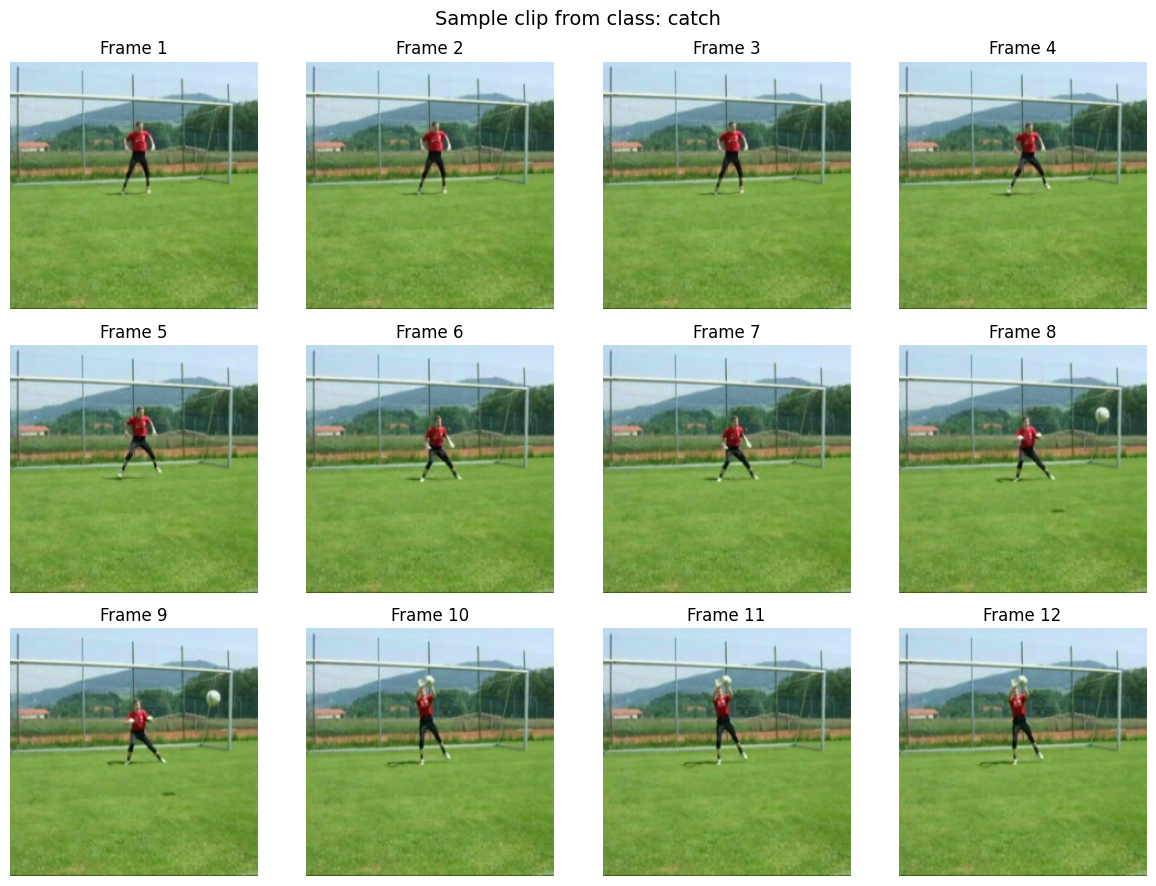

In [ ]:
sample_idx = 0
sample_frames, sample_label = train_dataset[sample_idx]
vis_frames = denormalize(sample_frames).cpu()
class_name = train_dataset.classes[sample_label]
frames_to_show = min(vis_frames.shape[0], 12)
cols = 4
rows = math.ceil(frames_to_show / cols)
plt.figure(figsize=(12, 3 * rows))
for i in range(frames_to_show):
    plt.subplot(rows, cols, i + 1)
    frame = vis_frames[i].permute(1, 2, 0).numpy()
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Frame {i + 1}')
plt.suptitle(f'Sample clip from class: {class_name}', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import timm

EPOCHS = 10
GRAD_ACCUM_STEPS = 16
BASE_LR = 5e-5
HEAD_LR = 2.5e-4
WEIGHT_DECAY = 0.05
PRETRAINED_NAME = 'vit_base_patch16_224'

weights_dir = './weights'
Path(weights_dir).mkdir(parents=True, exist_ok=True)
best_ckpt = Path(weights_dir) / 'lsvit_hmdb51_best.pt'
last_ckpt = Path(weights_dir) / 'lsvit_hmdb51_last.pt'

config = ViTConfig(image_size=IMG_SIZE)
model = LSViTForAction(config).to(DEVICE)
load_vit_checkpoint(model.backbone, PRETRAINED_NAME, weights_dir)

backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if name.startswith("backbone"):
        backbone_params.append(param)
    else:
        head_params.append(param)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": BASE_LR},
        {"params": head_params, "lr": HEAD_LR},
    ],
    weight_decay=WEIGHT_DECAY,
)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available()) # type: ignore

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        scaler,
        DEVICE,
        grad_accum_steps=GRAD_ACCUM_STEPS,
    )
    val_acc, val_loss = evaluate(model, val_loader, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    torch.save({'model': model.state_dict(), 'acc': val_acc}, last_ckpt)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({'model': model.state_dict(), 'acc': best_acc}, best_ckpt)

    print(
        f'Epoch {epoch + 1}/{EPOCHS} | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | '
        f'val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | best={best_acc:.4f}'
    )

trained_model = model
training_history = history

Loaded ViT weights from weights\vit_base_patch16_224_timm.pth
Missing keys: ['blocks.0.lmim.delta', 'blocks.0.lmim.reduce.weight', 'blocks.0.lmim.reduce.bias', 'blocks.0.lmim.expand.weight', 'blocks.0.lmim.expand.bias', 'blocks.0.lmim.temporal_mlp.0.weight', 'blocks.0.lmim.temporal_mlp.0.bias', 'blocks.0.lmim.temporal_mlp.1.weight', 'blocks.0.lmim.temporal_mlp.1.bias', 'blocks.0.lmim.temporal_mlp.3.weight', 'blocks.0.lmim.temporal_mlp.3.bias', 'blocks.1.lmim.delta', 'blocks.1.lmim.reduce.weight', 'blocks.1.lmim.reduce.bias', 'blocks.1.lmim.expand.weight', 'blocks.1.lmim.expand.bias', 'blocks.1.lmim.temporal_mlp.0.weight', 'blocks.1.lmim.temporal_mlp.0.bias', 'blocks.1.lmim.temporal_mlp.1.weight', 'blocks.1.lmim.temporal_mlp.1.bias', 'blocks.1.lmim.temporal_mlp.3.weight', 'blocks.1.lmim.temporal_mlp.3.bias', 'blocks.2.lmim.delta', 'blocks.2.lmim.reduce.weight', 'blocks.2.lmim.reduce.bias', 'blocks.2.lmim.expand.weight', 'blocks.2.lmim.expand.bias', 'blocks.2.lmim.temporal_mlp.0.weight',

Train:   0%|          | 0/1530 [00:00<?, ?it/s]

In [ ]:
epochs = range(1, len(training_history['train_loss']) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].plot(epochs, training_history['train_loss'], label='Train Loss')
axes[0].plot(epochs, training_history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()

axes[1].plot(epochs, training_history['train_acc'], label='Train Accuracy', color='blue')
axes[1].plot(epochs, training_history['val_acc'], label='Val Accuracy', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
trained_model.eval()
if best_ckpt.is_file():
    state = torch.load(best_ckpt, map_location=DEVICE)
    trained_model.load_state_dict(state['model'])

with torch.no_grad():
    sample_idx = random.randrange(len(val_dataset))
    sample_video, sample_label = val_dataset[sample_idx]
    logits = trained_model(sample_video.unsqueeze(0).to(DEVICE))
    probs = torch.softmax(logits, dim=1).cpu().squeeze(0)

pred_idx = int(probs.argmax())
pred_class = val_dataset.classes[pred_idx]
true_class = val_dataset.classes[sample_label]
confidence = float(probs[pred_idx])

vis_frames = denormalize(sample_video).cpu()
frames_to_show = min(vis_frames.shape[0], 12)
cols = 4
rows = math.ceil(frames_to_show / cols)
plt.figure(figsize=(12, 3 * rows))
for i in range(frames_to_show):
    plt.subplot(rows, cols, i + 1)
    frame = vis_frames[i].permute(1, 2, 0).numpy()
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Frame {i + 1}')
plt.suptitle(
    f'Predicted: {pred_class} ({confidence:.2%}) | Ground Truth: {true_class}', fontsize=14
)
plt.tight_layout()
plt.show()